#Notebook Introduction
This notebook explores a machine learning workflow for predicting teen phone addiction levels using boosting models with feature selection. The dataset contains behavioral and demographic features related to smartphone usage, and the goal is to accurately predict the addiction score. I compare between different tree-based models and apply the Boruta feature selection method to identify the most relevant predictors. The notebook covers the full pipeline, including basic preprocessing, model training, evaluation, and comparison before and after feature selection.

In [ ]:
'''
%pip install xgboost
%pip install Boruta
%pip install catboost
%pip install category_encoders
'''

'\n%pip install xgboost\n%pip install Boruta\n%pip install catboost\n%pip install category_encoders\n'

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder
from scipy import stats

import xgboost
import catboost
from boruta import BorutaPy



### Load Dataset
We begin by loading the dataset and displaying a few rows to understand the structure of the data. This helps us identify categorical and numerical columns, check for missing values, and plan preprocessing steps accordingly.

In [ ]:
data_path = 'teen_phone_addiction_dataset.csv'
df = pd.read_csv(data_path, encoding='ascii', delimiter=',')



Data Shape: (3000, 25)
Columns: ['ID', 'Name', 'Age', 'Gender', 'Location', 'School_Grade', 'Daily_Usage_Hours', 'Sleep_Hours', 'Academic_Performance', 'Social_Interactions', 'Exercise_Hours', 'Anxiety_Level', 'Depression_Level', 'Self_Esteem', 'Parental_Control', 'Screen_Time_Before_Bed', 'Phone_Checks_Per_Day', 'Apps_Used_Daily', 'Time_on_Social_Media', 'Time_on_Gaming', 'Time_on_Education', 'Phone_Usage_Purpose', 'Family_Communication', 'Weekend_Usage_Hours', 'Addiction_Level']


In [ ]:
# Display basic information about the dataset
print('Data Shape:', df.shape)
print('Columns:', df.columns.tolist())
df.describe()

In [ ]:
df.dtypes

,0
ID,int64
Name,object
Age,int64
Gender,object
Location,object
School_Grade,object
Daily_Usage_Hours,float64
Sleep_Hours,float64
Academic_Performance,int64
Social_Interactions,int64


In [ ]:
df.head()

,ID,Name,Age,Gender,Location,School_Grade,Daily_Usage_Hours,Sleep_Hours,Academic_Performance,Social_Interactions,...,Screen_Time_Before_Bed,Phone_Checks_Per_Day,Apps_Used_Daily,Time_on_Social_Media,Time_on_Gaming,Time_on_Education,Phone_Usage_Purpose,Family_Communication,Weekend_Usage_Hours,Addiction_Level
0,1,Shannon Francis,13,Female,Hansonfort,9th,4.0,6.1,78,5,...,1.4,86,19,3.6,1.7,1.2,Browsing,4,8.7,10.0
1,2,Scott Rodriguez,17,Female,Theodorefort,7th,5.5,6.5,70,5,...,0.9,96,9,1.1,4.0,1.8,Browsing,2,5.3,10.0
2,3,Adrian Knox,13,Other,Lindseystad,11th,5.8,5.5,93,8,...,0.5,137,8,0.3,1.5,0.4,Education,6,5.7,9.2
3,4,Brittany Hamilton,18,Female,West Anthony,12th,3.1,3.9,78,8,...,1.4,128,7,3.1,1.6,0.8,Social Media,8,3.0,9.8
4,5,Steven Smith,14,Other,Port Lindsaystad,9th,2.5,6.7,56,4,...,1.0,96,20,2.6,0.9,1.1,Gaming,10,3.7,8.6


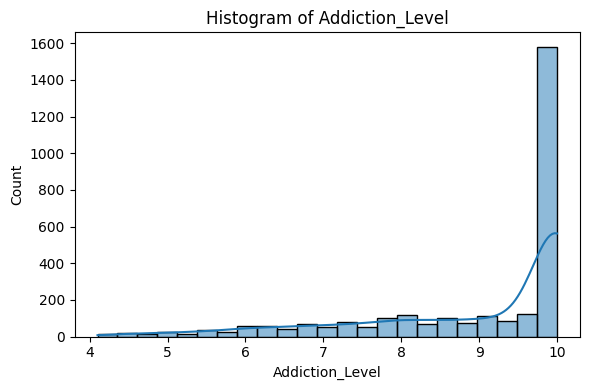

In [ ]:
# Plotting the distribution of the target column
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title(f'Histogram of Addiction_Level')
plt.tight_layout()
plt.show()

In [ ]:
#Check for missing values in dataset
df.isnull().sum()

,0
Age,0
Gender,0
Location,0
School_Grade,0
Daily_Usage_Hours,0
Sleep_Hours,0
Academic_Performance,0
Social_Interactions,0
Exercise_Hours,0
Anxiety_Level,0


In [ ]:
# Removal of irrelvent columns for training process
df.drop(['ID','Name'],axis=1,inplace=True)

In [ ]:
# Outliers removal
print(df.shape)
df_num_col = df.select_dtypes(include=['float64','int64']).columns.tolist()
df = df[(np.abs(stats.zscore(df[df_num_col]))<3).all(axis=1)]
print(df.shape)
%store df_num_col

(3000, 23)
(2921, 23)
Stored 'df_num_col' (list)


### Define Features and Target Variable
We separate the input features `X` and the target variable `y` (which represents the addiction score). This separation is essential for model training and evaluation.


In [ ]:
y = df['Addiction_Level']
df.drop('Addiction_Level',axis=1,inplace=True)

###indicate of imbalanced dataset
As we can see from the data below there is a imbalanced dataset where more than 50% of the data has the target value of 10.0 which is the maximum value.

In [ ]:
y.value_counts()

,count
Addiction_Level,
10.0,1503
9.9,50
7.8,45
9.6,45
8.0,44
9.4,43
9.5,43
9.3,42
9.0,41


In [ ]:
y[y==10.0].value_counts()/len(y)

,count
Addiction_Level,
10.0,0.51455


###Split Data into Training and Test Sets
We split the data into training and testing subsets to evaluate model performance on unseen data. We use a 70/30 split for training and testing respectively.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=42)


###Target Encoding for Categorical Features

In this section, we apply target encoding to categorical features- replaces each category with the mean of the target variable for that category.


In [ ]:
t_encoder = TargetEncoder(smoothing = 1.0,drop_invariant=True)
t_encoder.fit(X_train, y_train)
X_train_cat = X_train.copy()
X_test_cat = X_test.copy()
X_train = t_encoder.transform(X_train)
X_test = t_encoder.transform(X_test)

In [ ]:
# Finding the catagorial features for the catboost model
cat_features_list = X_train_cat.select_dtypes(include=['object',]).columns.tolist()
cat_features_list

['Gender', 'Location', 'School_Grade', 'Phone_Usage_Purpose']

###Exploratory Check: Training Set Structure Check before train process


In [ ]:
print(X_train.shape)
print(X_train.columns)
print(X_train.dtypes)
X_train.head()

(2044, 21)
Index(['Age', 'Gender', 'School_Grade', 'Daily_Usage_Hours', 'Sleep_Hours',
       'Academic_Performance', 'Social_Interactions', 'Exercise_Hours',
       'Anxiety_Level', 'Depression_Level', 'Self_Esteem', 'Parental_Control',
       'Screen_Time_Before_Bed', 'Phone_Checks_Per_Day', 'Apps_Used_Daily',
       'Time_on_Social_Media', 'Time_on_Gaming', 'Time_on_Education',
       'Phone_Usage_Purpose', 'Family_Communication', 'Weekend_Usage_Hours'],
      dtype='object')
Age                         int64
Gender                    float64
School_Grade              float64
Daily_Usage_Hours         float64
Sleep_Hours               float64
Academic_Performance        int64
Social_Interactions         int64
Exercise_Hours            float64
Anxiety_Level               int64
Depression_Level            int64
Self_Esteem                 int64
Parental_Control            int64
Screen_Time_Before_Bed    float64
Phone_Checks_Per_Day        int64
Apps_Used_Daily             int64
Time_o

,Age,Gender,School_Grade,Daily_Usage_Hours,Sleep_Hours,Academic_Performance,Social_Interactions,Exercise_Hours,Anxiety_Level,Depression_Level,...,Parental_Control,Screen_Time_Before_Bed,Phone_Checks_Per_Day,Apps_Used_Daily,Time_on_Social_Media,Time_on_Gaming,Time_on_Education,Phone_Usage_Purpose,Family_Communication,Weekend_Usage_Hours
457,18,8.891207,8.940179,5.1,7.1,85,8,0.9,1,1,...,0,0.0,39,7,2.4,1.3,0.5,8.926841,5,2.2
1368,18,8.891207,9.012607,5.1,7.2,52,8,2.0,3,10,...,1,1.8,74,12,2.9,1.3,1.7,9.029820,1,6.1
2439,17,8.980059,8.910482,8.4,6.1,54,0,1.2,3,2,...,1,0.8,94,19,1.8,0.2,1.4,8.990932,8,2.2
1100,19,8.980059,8.940179,7.0,5.1,99,1,0.3,7,4,...,1,0.9,31,9,3.7,0.0,1.4,8.990932,2,4.1
86,13,8.891207,8.940179,7.3,5.6,84,1,0.2,4,1,...,0,1.2,22,11,2.2,2.0,0.9,9.009767,1,4.1


###Train Initial Random Forest Regressor (All Features)

In [ ]:
model_rf = RandomForestRegressor(
    n_estimators=100,     # number of trees
    max_depth=10,         # limit depth to avoid overfitting
    max_features='sqrt',
    random_state=42)
model_rf.fit(X_train, y_train)
print(f"RF train score : {model_rf.score(X_train, y_train)}")

#predict & creating R2 score

prediction_rf = model_rf.predict(X_test)
print(f'R2 score for RF model :{r2_score(y_test, prediction_rf)}')


RF train score : 0.9243205004987175
R2 score for RF model :0.7030611922547807


###Train Initial XGBoost Regressor (All Features)

In [ ]:
model_xgb = xgboost.XGBRegressor(
    n_estimators=100,        # number of boosting rounds
    max_depth=5,             # max depth of each tree
    learning_rate=0.1,       # shrinkage rate (step size)
    subsample=0.8,           # % of training data to use per tree
    colsample_bytree=0.8,    # % of features per tree
    random_state=42
)
model_xgb.fit(X_train, y_train)
print(f"XGB train score : {model_rf.score(X_train, y_train)}")

#predict & creating R2 score

prediction_xgb = model_xgb.predict(X_test)
print(f'R2 score for XGB model :{r2_score(y_test, prediction_xgb)}')


XGB train score : 0.9243205004987175
R2 score for XGB model :0.8976243852463655


###Train Initial CatBoost Regressor (All Features)

In [ ]:
model_cat  = catboost.CatBoostRegressor(
    iterations=100,         # number of boosting rounds
    depth=5,                # max depth of each tree
    learning_rate=0.1,      # shrinkage rate
    random_seed=42,
    verbose=10,             # show progress every 10 itr
    cat_features= cat_features_list
)
model_cat.fit(X_train_cat, y_train)
print(f"CATBST train score : {model_cat.score(X_train_cat, y_train)}")

#predict & creating R2 score

prediction_cat = model_cat.predict(X_test_cat)
catboost_r2_score_full_dim = r2_score(y_test, prediction_cat)
print(f'R2 score for CatBoost model :{catboost_r2_score_full_dim}')


0:	learn: 1.3988870	total: 2.13ms	remaining: 211ms
10:	learn: 0.9401652	total: 18.1ms	remaining: 146ms
20:	learn: 0.6993386	total: 36.8ms	remaining: 139ms
30:	learn: 0.5648847	total: 54.3ms	remaining: 121ms
40:	learn: 0.4767128	total: 69.4ms	remaining: 99.9ms
50:	learn: 0.4261087	total: 84.2ms	remaining: 80.9ms
60:	learn: 0.3847364	total: 99.3ms	remaining: 63.5ms
70:	learn: 0.3497117	total: 116ms	remaining: 47.2ms
80:	learn: 0.3236920	total: 132ms	remaining: 31ms
90:	learn: 0.2981658	total: 148ms	remaining: 14.6ms
99:	learn: 0.2813473	total: 163ms	remaining: 0us
CATBST train score : 0.9632221782098531
R2 score for CatBoost model :0.9375767512388035


###Feature Selection with Boruta
We apply the Boruta feature selection method, which is built on top of a Random Forest model. It helps us identify and keep only the features that are statistically important to the target. This reduces dimensionality and may improve generalization.


In [ ]:
# Boruta algo for dimensionality reduction

model = RandomForestRegressor(max_depth=10)
feature_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=42)

feature_selector.fit(X_train, y_train)

# show selected features
print(feature_selector.support_)  #Should we accept the feature

# show ranking of features
print(feature_selector.ranking_) #Rank 1 is the best



Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	6
Tentative: 	0
Rejected: 	15


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	6
Tentative: 	0
Rejected: 	15
[False False False  True  True False False False False False False False
 False  True  True  True  True False False False False]
[13 14 12  1  1  2  8  3 10  7  7 15  5  1  1  1  1  4 11  9  2]


###Filter Dataset with Selected Features

In [ ]:
# Filtering Dataset according to Boruta algorithm
selected_features = X_train.columns[feature_selector.support_]
X_train_filter = X_train[selected_features]
X_test_filter = X_test[selected_features]
print(X_train_filter.shape)
X_train_filter.head()

(2044, 6)


,Daily_Usage_Hours,Sleep_Hours,Phone_Checks_Per_Day,Apps_Used_Daily,Time_on_Social_Media,Time_on_Gaming
457,5.1,7.1,39,7,2.4,1.3
1368,5.1,7.2,74,12,2.9,1.3
2439,8.4,6.1,94,19,1.8,0.2
1100,7.0,5.1,31,9,3.7,0.0
86,7.3,5.6,22,11,2.2,2.0


###Train CatBoost Model with Selected Features

In [ ]:
model_cat  = catboost.CatBoostRegressor(
    iterations=100,         # number of boosting rounds
    depth=5,                # max depth of each tree
    learning_rate=0.1,      # shrinkage rate
    random_seed=42,
    verbose=10,             # show progress every 10 itr
)
model_cat.fit(X_train_filter, y_train)
print(f"CATBST train score : {model_cat.score(X_train_filter, y_train)}")

#predict & creating R2 score

prediction_cat = model_cat.predict(X_test_filter)
catboost_r2_score_boruta = r2_score(y_test, prediction_cat)
print(f'R2 score for CatBoost model :{r2_score(y_test, prediction_cat)}')


0:	learn: 1.3967316	total: 908us	remaining: 90ms
10:	learn: 0.9375352	total: 8.67ms	remaining: 70.1ms
20:	learn: 0.6969722	total: 15.3ms	remaining: 57.4ms
30:	learn: 0.5629759	total: 22ms	remaining: 49ms
40:	learn: 0.4730534	total: 28.4ms	remaining: 40.9ms
50:	learn: 0.4206218	total: 34.7ms	remaining: 33.4ms
60:	learn: 0.3706938	total: 41.3ms	remaining: 26.4ms
70:	learn: 0.3402605	total: 47.5ms	remaining: 19.4ms
80:	learn: 0.3132838	total: 53.5ms	remaining: 12.6ms
90:	learn: 0.2921346	total: 59.7ms	remaining: 5.9ms
99:	learn: 0.2754635	total: 65.1ms	remaining: 0us
CATBST train score : 0.9648325673679059
R2 score for CatBoost model :0.9375242552710562


###Evaluate Model Performance and Compare
We compare the R² score of the baseline model (all features) with the model trained on the selected features. We can see that even though we elimnated 70% of the features R2 score stayed very high.


In [ ]:
print(f"First CATBOOST model with {X_train.shape[1]} features:{catboost_r2_score_full_dim:.4f}")
print(f"Second CATBOOST model with {X_train_filter.shape[1]} features:{catboost_r2_score_boruta:.4f}")
print(f"R2 Score loss after dimensionality reduction: {(catboost_r2_score_full_dim-catboost_r2_score_boruta):.4f}")

First CATBOOST model with 21 features:0.9376
Second CATBOOST model with 6 features:0.9375
R2 Score loss after dimensionality reduction: 0.0001
